In [1]:
import torch
from torchvision.models import resnet50
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


/home/tkg5kq/.conda/envs/video2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
import sys
sys.path.insert(0, "./../explain/ml-no-token-left-behind/external/tamingtransformers")
sys.path.append("./../explain/ml-no-token-left-behind/external/TransformerMMExplainability")
# from ntlb import load_classifier
from torch import nn
from dotmap import DotMap
import yaml
from modules.Visual_Prompt import visual_prompt
from CLIP.clip import clip
from TSSTANET.tsstanet import tanet, sanet, stanet, stanet_af
from prompt import *

In [30]:

def load_classifier(pretrain):
    if os.path.isfile(pretrain):
        print(("=> loading checkpoint '{}'".format(pretrain)))
        checkpoint = torch.load(pretrain)
        model.load_state_dict(checkpoint['model_state_dict'])
        fusion_model.load_state_dict(checkpoint['fusion_model_state_dict'])
        del checkpoint
    else:
        print(("=> no checkpoint found at '{}'".format(pretrain)))

    return model, fusion_model

def get_models(config_file):
    # config_file = '/scratch/tkg5kq/sandbox/bounding_box/comparison/ActionCLIP/exp/clip_k400/ViT-B/32/education6/FULL_BEST_ACTION/generic_prompts_bb_train.yaml'
    with open(config_file, 'r') as f:
        config = yaml.safe_load(f)
    config = DotMap(config)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, clip_state_dict = clip.load(config.network.arch, device=device, jit=False, tsm=config.network.tsm,
                                                    T=config.data.num_segments, dropout=config.network.drop_out,
                                                    emb_dropout=config.network.emb_dropout)  # Must set jit=False for training  ViT-B/32


    fusion_model = visual_prompt(config.network.sim_header, clip_state_dict, config.data.num_segments)
    model_stan = stanet_af(layers=[2, 2, 2, 2], in_channels=3, num_classes=6, k=2, features=16)

    model_text = TextCLIP(model)
    model_image = ImageCLIP(model)

    model_text = torch.nn.DataParallel(model_text).cuda()
    model_image = torch.nn.DataParallel(model_image).cuda()
    model_stan = torch.nn.DataParallel(model_stan).cuda()
    fusion_model = torch.nn.DataParallel(fusion_model).cuda()
    model, fusion_model = load_classifier(config.pretrain)
    model_image.requires_grad_(True)
    model_text.requires_grad_(True)
    fusion_model.requires_grad_(True)
    model.requires_grad_(True)
    return model, config, fusion_model, model_text, model_image, model_stan


In [31]:
config_file = '/scratch/tkg5kq/sandbox/bounding_box/comparison/ActionCLIP/exp/clip_k400/ViT-B/32/education6/FULL_BEST_RUN_BB/generic_prompts_bb_train.yaml'
model, config, fusion_model, model_text, model_image, model_san = get_models(config_file)
mask_transform = get_mask_augmentation(cut_size=224, 
                                    cutn=1, 
                                    cut_pow=1., 
                                    noise_fac = 0.1)

dropout used:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
dropout used:[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
loading clip pretrained model!
layer=6
=> loading checkpoint '/scratch/tkg5kq/sandbox/bounding_box/comparison/ActionCLIP/exp/clip_k400/ViT-B/32/education6/FULL_BEST_RUN_BB/model_best.pt'


In [32]:

def collate_fn(batch):
    videos, masks, lambda_val, labels = zip(*batch)
    # Check the labels for bb
    videos, labels = torch.stack(videos), torch.tensor(labels)
    lambda_val = torch.tensor(lambda_val)
    masks = torch.stack(masks, dim=0)
    # videos = videos.view((-1,config.data.num_segments,3)+videos.size()[-2:])
    # masks = masks.view((-1,config.data.num_segments,3)+masks.size()[-2:])
    masks = masks.squeeze(dim=1)
    videos = videos.squeeze(dim=1)
    data = {'videos': videos, 'masks': masks}
    iii, aug_masks = mask_transform(data)
    # iii = iii.squeeze()
    return videos, (aug_masks, lambda_val), labels

transform_val = get_augmentation(False, config)
val_data = Action_DATASETS(
                config.data.val_list,
                config.data.label_list, 
                random_shift=False,
                num_segments=config.data.num_segments,
                image_tmpl=config.data.image_tmpl,
                image_transform=transform_val)
val_loader = DataLoader(
                val_data,
                batch_size=config.data.batch_size,
                num_workers=config.data.workers,
                shuffle=False,
                pin_memory=False,
                drop_last=True,
                collate_fn=collate_fn)

In [83]:
model = model.eval()
classes, num_text_aug, text_dict = text_prompt(val_data, file_name=config.prompt)


In [84]:
from torchvision import transforms
import cv2

classes

tensor([[49406,   530,   589,  ...,     0,     0,     0],
        [49406,   530,   589,  ...,     0,     0,     0],
        [49406,   530,   589,  ...,     0,     0,     0],
        ...,
        [49406,   518,  4008,  ...,     0,     0,     0],
        [49406,   518,  4008,  ...,     0,     0,     0],
        [49406,   518,  4008,  ...,     0,     0,     0]])

In [61]:
from utils import tools
class PredModel(torch.nn.Module):
    def __init__(self, model):
        super(PredModel, self).__init__()
        self.model = model

    def forward(self, x):
        b = 1
        t, c, h,w = x.shape
        text_inputs = classes.to(device)
        text_features = model.encode_text(text_inputs)
        x = x.unsqueeze(0)
        image_features = self.model.encode_image(x.squeeze())
        image_features = image_features.view(b, t,-1)
        image_features = fusion_model(image_features)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logit_scale = self.model.logit_scale.exp()
        logits_per_image, logits_per_text = create_logits(image_features,text_features,logit_scale)
        return logits_per_image, logits_per_text

def reshape_transform(tensor, height=27, width=27):
    # t = tensor[0]
    b, t, c = tensor.shape
    print(tensor.shape)
    # result = tensor.reshape(b, -1)
    # result = result[:, 0:result.size(1)-60]
    result = tensor.permute(0, 2, 1)
    print(result.shape)
    result = result[:, 0:729, :]
    print(result.shape)
    result = result.reshape(b, height, width, t)
    print(result.shape)

    # result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcamplusplus(video, model, target_layers, reshape_transform):
  pred_model = PredModel(model)
  pred_model.eval()
  # reshape_transform = transforms.Compose([])#ThisTransform()])
  # Construct the CAM object once, and then re-use it on many images.
  with GradCAMPlusPlus(model=pred_model, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
    cam.batch_size = 1
    print(f'Max: {torch.max(video)}, {video.shape}')
  #   torch.autograd.set_detect_anomaly(True)
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    # print(video.shape)
    grayscale_cam = cam(input_tensor=video, targets=targets)
    # In this example grayscale_cam has only one image in the batch:
    # print(grayscale_cam.shape)
    
  return grayscale_cam

In [79]:
import matplotlib.cm as cm
def print_frames(video, grayscale_cam):
    for i in range(8):
        np.max(video.cpu().numpy())
        # print(len(video[0][i].cpu().numpy()))
        # print(label)
        input_vid = video[i].cpu().permute(1, 2, 0).numpy()
        visualization = show_cam_on_image(input_vid, grayscale_cam[-1, ...], use_rgb=True)
        # You can also get the model outputs without having to redo inference
        cam_image = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)
        # model_outputs = cam.outputs

        # gnd_truth = 'Havanese'
        # dog_pred = train_subset._label_names[int(argmax)]

        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow((input_vid + 1) / 2)
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(cam_image)
        plt.axis('off')
        plt.show()


torch.Size([1, 8, 3, 224, 224])
torch.Size([1, 8, 3, 224, 224])
0
Max: 1.0, torch.Size([8, 3, 224, 224])
torch.Size([50, 8, 768])
torch.Size([50, 768, 8])
torch.Size([50, 729, 8])
torch.Size([50, 27, 27, 8])
torch.Size([50, 8, 768])
torch.Size([50, 768, 8])
torch.Size([50, 729, 8])
torch.Size([50, 27, 27, 8])


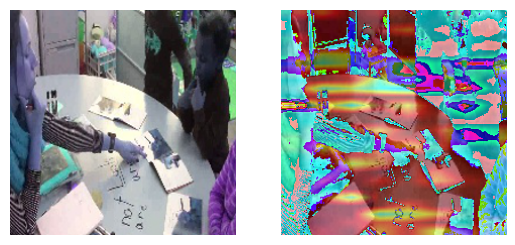

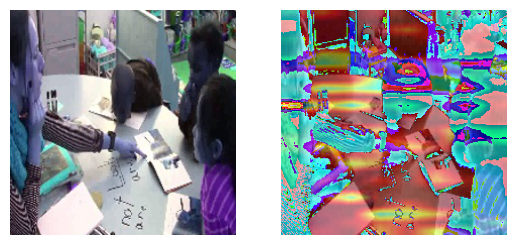

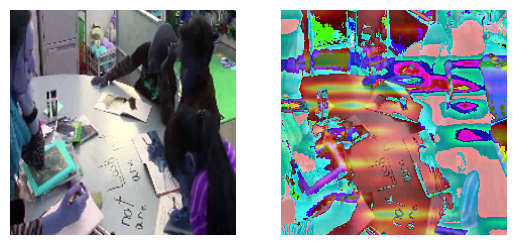

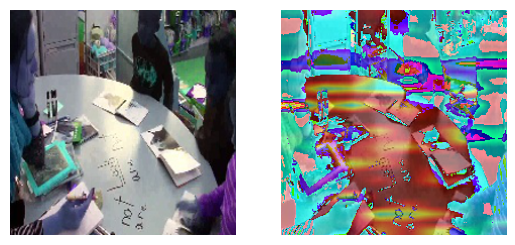

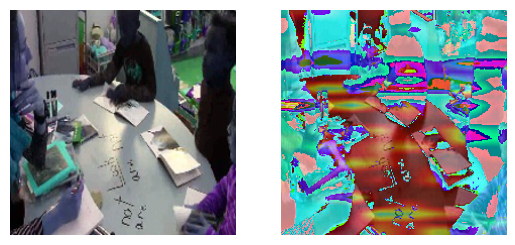

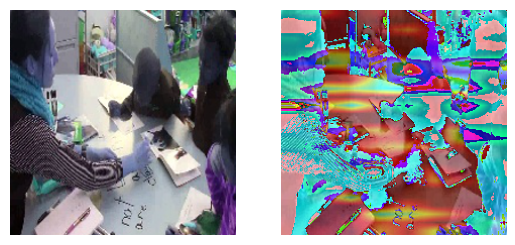

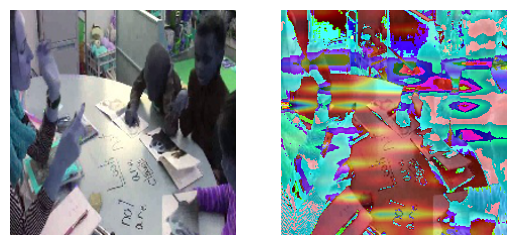

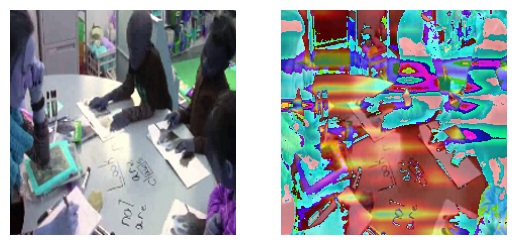

In [85]:

vid_num = 3
video, mask, mask2, label = val_data[vid_num]
video = video.to(device)
image_embedding = model.encode_image(video[0])
print(video.shape)

print(video.shape)

model2 = PredModel(model)
logits_per_image, logits_per_text = model2(video[0])
similarity = logits_per_image.view(1, num_text_aug, -1).softmax(dim=-1)
similarity = similarity.mean(dim=1, keepdim=False)
answer = torch.argmax(similarity, dim=1).to(dtype=int)
print(int(answer))

# We have to specify the target we want to generate the CAM for.
index = int(answer)
targets = [ClassifierOutputTarget(index)]
target_layer = model.visual.transformer.resblocks[0].ln_1
target_layers = [target_layer]
grayscale_cam = get_gradcamplusplus(video[0], model, target_layers, reshape_transform)
# grayscale_cam.shape
print_frames(video[0], grayscale_cam)